In [2]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import platform

# 시스템이 Windows일 경우
if platform.system() == 'Windows':
    plt.rc('font', family='Pretendard')
# macOS일 경우 예시:
elif platform.system() == 'Darwin':
    plt.rc('font', family='AppleGothic')

# 마이너스 부호 깨짐 방지
plt.rcParams['axes.unicode_minus'] = False

In [3]:
# 2. 신용정보
features_credit = [
    '최초한도금액',
    '카드이용한도금액', 'CA한도금액',
    '일시상환론한도금액', '월상환론한도금액',
    'CA이자율_할인전',
    'RV일시불이자율_할인전', 'RV현금서비스이자율_할인전',
    'RV약정청구율', 'RV최소결제비율',
    '한도증액횟수_R12M',
    '한도증액금액_R12M', '상향가능CA한도금액', '월상환론상향가능한도금액',
    '일시불ONLY전환가능여부', '특별한도보유여부_R3M', '연체감액여부_R3M'
]

In [4]:
selected_feature=(
    features_credit)

In [5]:
print(len(selected_feature))         
print(type(selected_feature[0]))     
# 171 --> 119

17
<class 'str'>


In [6]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report
from xgboost import XGBClassifier

# 1. 데이터 불러오기
df = pd.read_parquet("../../data/통합_train_데이터.parquet")

# 2. 피처 및 타겟 분리
X = df[selected_feature].copy()
y = df["Segment"]

# 3. 범주형 인코딩
cat_cols = X.select_dtypes(include='object').columns.tolist()
for col in cat_cols:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col].astype(str))

# 4. 결측치 처리
X = pd.DataFrame(SimpleImputer(strategy='mean').fit_transform(X), columns=X.columns)

# 스케일링 (DataFrame 형태 유지)
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

# 라벨인코딩
le_y = LabelEncoder()
y_encoded = le_y.fit_transform(y)

# 6. train-validation 분할
X_train, X_val, y_train, y_val = train_test_split(X_scaled, y_encoded, test_size=0.2, stratify=y_encoded, random_state=42)

# 7. XGBoost 모델 선언 (GPU 가속)
xgb_model = XGBClassifier(
    tree_method='gpu_hist',
    predictor='gpu_predictor',
    n_estimators=300,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    use_label_encoder=False,
    eval_metric='mlogloss',
    random_state=42
)

# 8. 학습
xgb_model.fit(X_train, y_train)

# 9. 예측 및 평가
y_pred = xgb_model.predict(X_val)
print(classification_report(y_val, y_pred))


c:\Users\somee\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:08:28] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\somee\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:08:28] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\somee\anaconda3\Lib\site-packages\xgboost\core.py:2676: UserWarning: [16:08:52] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  if len(data.s

              precision    recall  f1-score   support

           0       0.62      0.14      0.23       194
           1       1.00      0.07      0.13        29
           2       0.58      0.25      0.35     25518
           3       0.55      0.23      0.32     69848
           4       0.85      0.97      0.91    384411

    accuracy                           0.83    480000
   macro avg       0.72      0.33      0.39    480000
weighted avg       0.79      0.83      0.79    480000



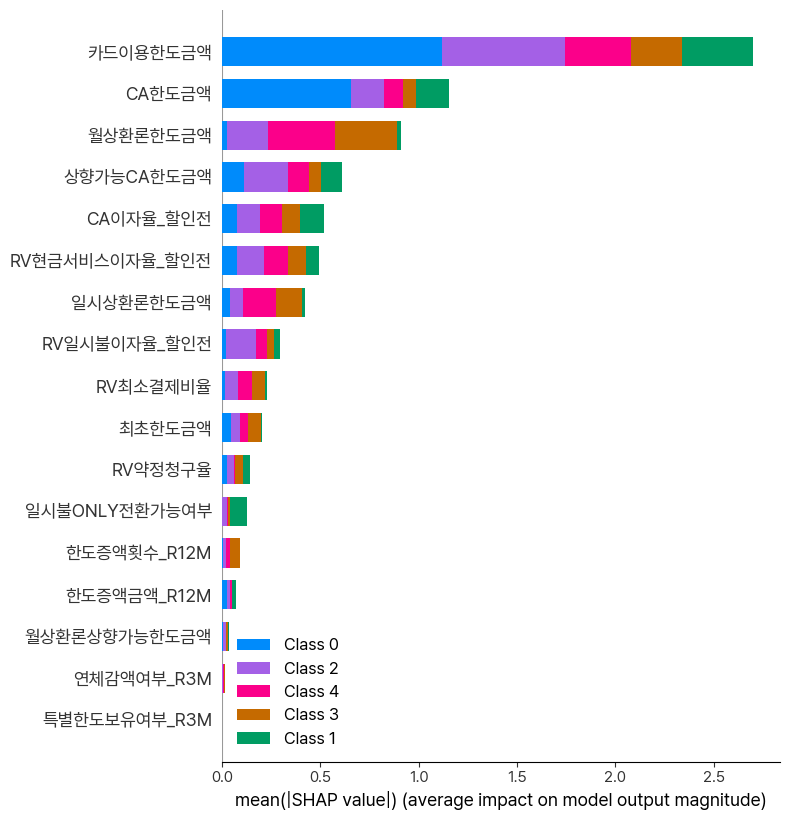

In [7]:
import shap

explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_val)

shap.summary_plot(shap_values, X_val, plot_type="bar")

In [8]:
import pandas as pd

importance_df = pd.DataFrame({
    "Feature": X.columns,
    "Importance": xgb_model.feature_importances_
}).sort_values(by="Importance", ascending=False)

display(importance_df.head(30))

,Feature,Importance
1,카드이용한도금액,0.155651
4,월상환론한도금액,0.122146
16,연체감액여부_R3M,0.104856
12,상향가능CA한도금액,0.090545
5,CA이자율_할인전,0.085628
2,CA한도금액,0.069700
3,일시상환론한도금액,0.066213
7,RV현금서비스이자율_할인전,0.054687
10,한도증액횟수_R12M,0.047101
9,RV최소결제비율,0.040651


 99%|===================| 958/970 [00:44<00:00]        

🔍 SHAP beeswarm plot for Segment 0


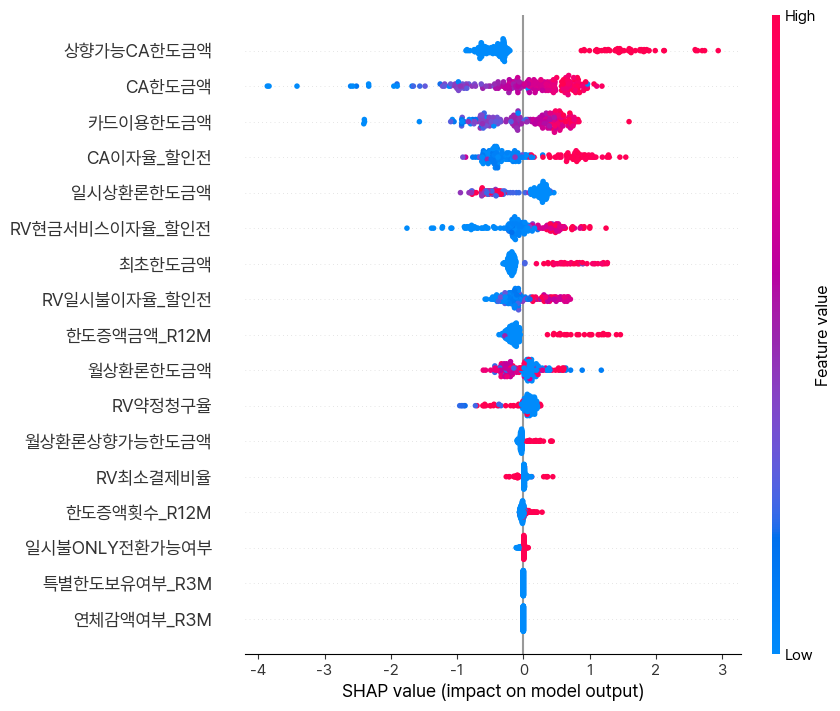

🔍 SHAP beeswarm plot for Segment 1


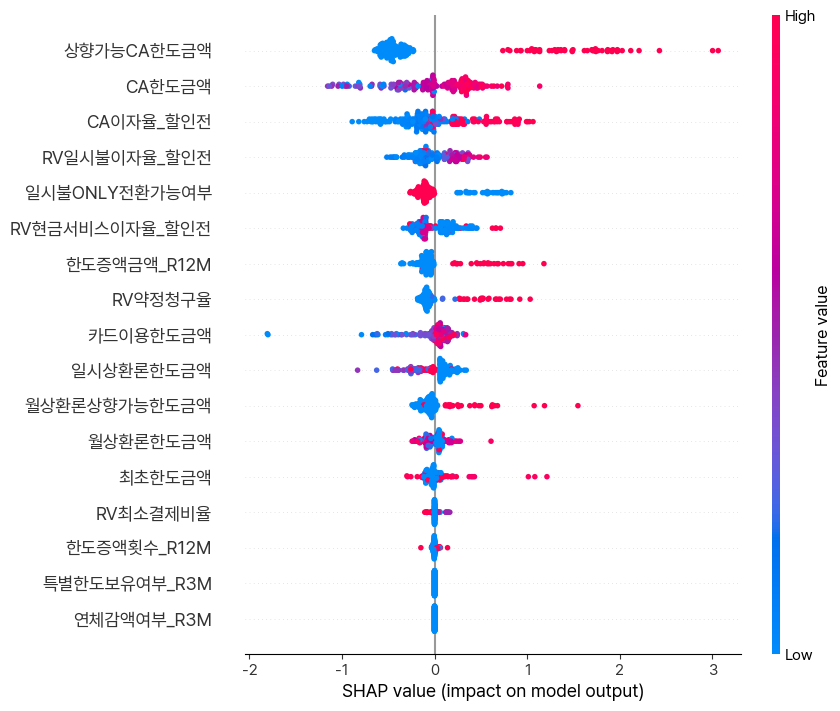

🔍 SHAP beeswarm plot for Segment 2


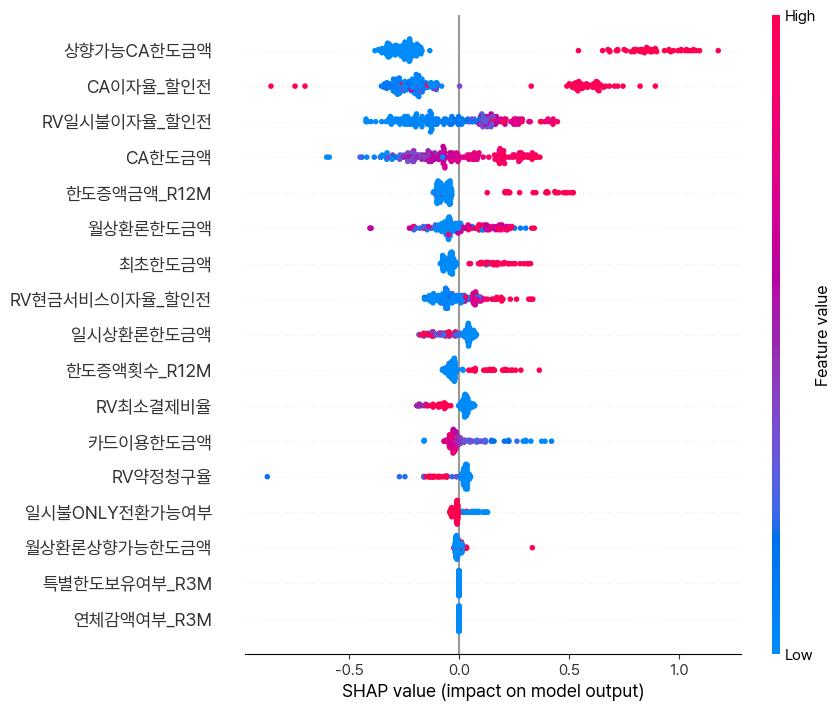

🔍 SHAP beeswarm plot for Segment 3


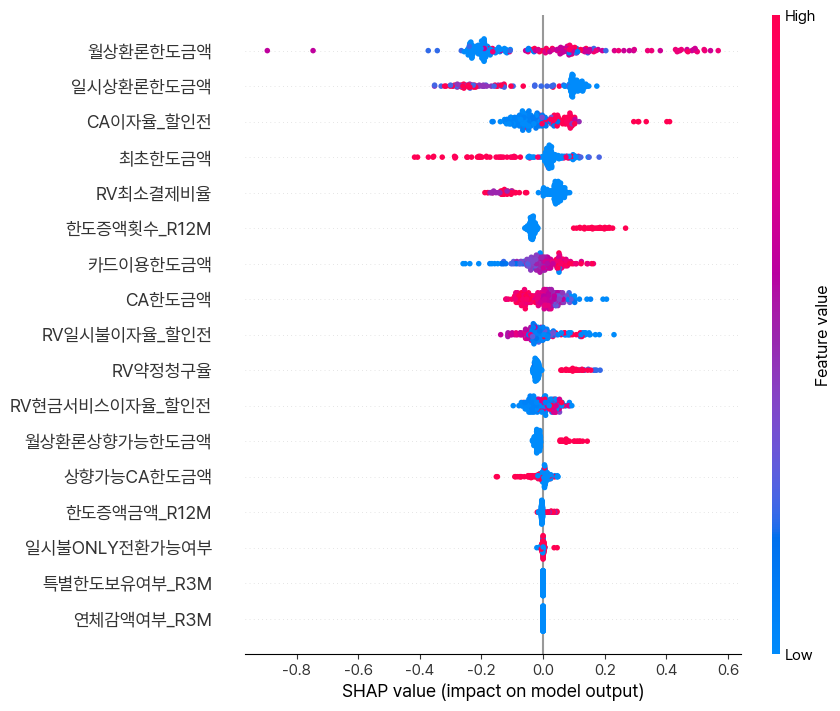

🔍 SHAP beeswarm plot for Segment 4


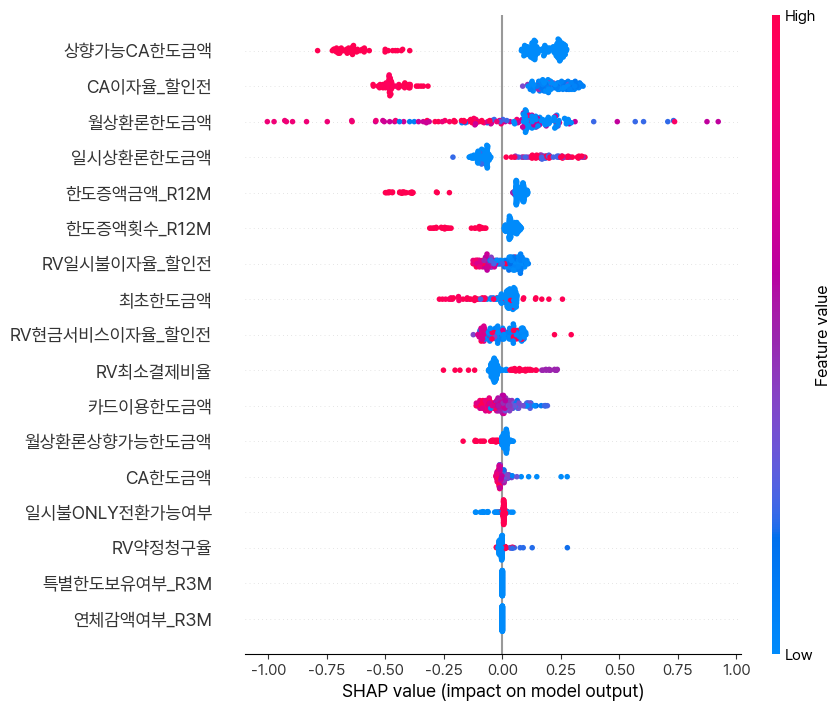

In [10]:
import shap  
import pandas as pd

# Segment 0 마스킹 + 데이터 준비
mask_0 = y_val == 0
X_val_df = pd.DataFrame(X_val, columns=selected_feature)
X_val_0_all = X_val_df[mask_0]

# 샘플 수 조정
n_samples = min(len(X_val_0_all), 300)
X_val_0 = X_val_0_all.sample(n=n_samples, random_state=42)

# SHAP 해석
explainer = shap.Explainer(xgb_model, X_val_0)
shap_values_0 = explainer(X_val_0)

for i in range(5):  # Segment 0 ~ 4
    print(f"🔍 SHAP beeswarm plot for Segment {i}")
    shap.plots.beeswarm(shap_values_0[:, :, i], max_display=20)

### 영향력있는 다른 컬럼 비교

In [ ]:
import pandas as pd

# 1. Parquet 파일 불러오기
file_path = "../../data/merged/승인매출정보_train.parquet"
df = pd.read_parquet(file_path)

# 2. 키워드가 포함된 컬럼만 필터링
keywords = ["한도금액", "연체감액여부"]
selected_cols = [col for col in df.columns if any(k in col for k in keywords)]

# 3. 선택된 컬럼만 추출한 데이터프레임 생성
df_selected = df[selected_cols].copy()

# 4. 결과 출력
print(f"선택된 컬럼 수: {len(selected_cols)}")
print("컬럼 목록:", selected_cols)
print(df_selected.head())

선택된 컬럼 수: 11
컬럼 목록: ['최초한도금액', '카드이용한도금액', 'CA한도금액', '일시상환론한도금액', '월상환론한도금액', '상향가능한도금액', '상향가능CA한도금액', '월상환론상향가능한도금액', '카드이용한도금액_B1M', '카드이용한도금액_B2M', '연체감액여부_R3M']
   최초한도금액  카드이용한도금액  CA한도금액  일시상환론한도금액  월상환론한도금액  상향가능한도금액  상향가능CA한도금액  \
0       0     19354    7270          0         0         0           0   
1       0      9996    5718      41996     90611         4           1   
2       0     88193   35207          0         0         0           0   
3       0     19062    6531          0         0         0           0   
4       0    177222   47149      48000    155020         0           0   

   월상환론상향가능한도금액  카드이용한도금액_B1M  카드이용한도금액_B2M  연체감액여부_R3M  
0             0         20805         19723           0  
1             0         10000          9998           0  
2             0         78730         77975           0  
3             0         20523         19226           0  
4             0        169667        168681           0  
